# Why Loss Re-weighting Works If You Stop Early: Training Dynamics of Unconstrained Features

This notebook contains two complementary experiments that illustrate how class imbalance affects learning dynamics—both in practical neural network settings and in idealized, theory-driven models.

## Part 1: Motivating Experiment – Class Imbalance in MNIST
This section empirically investigates how class imbalance influences training outcomes in deep learning. Using a 3-layer CNN on a 4-class subset of MNIST with a synthetic 10:1 imbalance ratio, we compare:
- Standard Cross-Entropy Loss (CE)
- Weighted Cross-Entropy Loss (WCE)

We track class-wise loss, accuracy, and confusion matrices over training to reveal that:
- CE prioritizes majority-class learning, delaying minority-class performance.
- WCE reshapes the learning dynamics, enabling earlier and more balanced learning.

This experiment motivates the need for a theoretical understanding of how loss reweighting alters training behavior.

## Part 2: Small-Scale Model – Spectral Analysis and UFM simulation
This section analyzes the same imbalance problem in a simplified setting using a small-scale Unconstrained Features Model (UFM) trained with squared loss.
- We decompose the label matrix into singular vectors, which represent key semantic directions (e.g., majority-majority, majority-minority, minority-minority).
- We simulate training with and without reweighting, showing that:
  - Standard training learns dominant singular components first, reinforcing imbalance.
  - Reweighting equalizes singular values, leading to simultaneous concept learning.

This spectral perspective explains why loss reweighting improves early-stage performance and supports the empirical observations in Part 1.

Each part is self-contained and runnable independently.

# Part 1: Motivating Experiment – Class Imbalance in MNIST

This section implements and analyzes training with standard and weighted cross-entropy loss on an imbalanced subset of MNIST.

## 1. Imports and Setup

First, let's import all necessary libraries and configure the environment.

In [11]:
!pip install torch torchvision numpy matplotlib seaborn scikit-learn imageio

In [12]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import imageio

# Set matplotlib to display plots inline (for Jupyter)
%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

## 2. Dataset Implementation

Define the dataset handling classes for MNIST data with class imbalance.

In [13]:
class RemappedDataset(Dataset):
    def __init__(self, subset, label_map, dataset_handler):
        self.subset = subset
        self.label_map = label_map
        self.dataset_handler = dataset_handler

    def __getitem__(self, idx):
        data, label = self.subset[idx]
        return data, self.label_map[label]

    def __len__(self):
        return len(self.subset)

class DatasetHandler:
    def __init__(self, c_maj, c_min, n):
        self.c_maj = c_maj
        self.c_min = c_min
        self.n = n
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=self.transform)
        self.test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=self.transform)

        # Create label mapping
        all_classes = c_maj + c_min
        self.label_map = {old_label: new_label for new_label, old_label in enumerate(all_classes)}
        self.reverse_label_map = {new_label: old_label for old_label, new_label in self.label_map.items()}

        # Store remapped class information
        self.remapped_c_maj = [self.label_map[c] for c in c_maj]
        self.remapped_c_min = [self.label_map[c] for c in c_min]

    def _get_indices(self, dataset, classes, n_per_class):
        indices = {cls: [] for cls in classes}
        for idx, (data, target) in enumerate(dataset):
            if target in classes:
                indices[target].append(idx)
        return indices

    def _create_subset(self, dataset, indices, classes, n_per_class):
        selected_indices = []
        for cls in classes:
            selected_indices.extend(indices[cls][:n_per_class])
        return Subset(dataset, selected_indices)

    def load_data(self):
        # Get indices for training data
        train_indices = self._get_indices(self.train_dataset, self.c_maj + self.c_min, self.n)

        # Create training subsets
        major_train_indices = []
        minor_train_indices = []
        for cls in self.c_maj:
            major_train_indices.extend(train_indices[cls][:10 * self.n])
        for cls in self.c_min:
            minor_train_indices.extend(train_indices[cls][:self.n])

        # Combine training indices
        train_combined_indices = major_train_indices + minor_train_indices
        train_subset = Subset(self.train_dataset, train_combined_indices)
        train_subset = RemappedDataset(train_subset, self.label_map, self)
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

        # Get indices for test data
        test_indices = self._get_indices(self.test_dataset, self.c_maj + self.c_min, 20)

        # Create test subsets (20 images per class)
        major_test_indices = []
        minor_test_indices = []
        for cls in self.c_maj:
            major_test_indices.extend(test_indices[cls][:20])
        for cls in self.c_min:
            minor_test_indices.extend(test_indices[cls][:20])

        # Combine test indices
        test_combined_indices = major_test_indices + minor_test_indices
        test_subset = Subset(self.test_dataset, test_combined_indices)
        test_subset = RemappedDataset(test_subset, self.label_map, self)
        test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

        return train_loader, test_loader

## 3. Model Implementation

Define the CNN and MLP model architectures.

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes, width=32, depth=2, hidden_factor=0.5):
        super(CNN, self).__init__()
        layers = []
        in_channels = 1
        for _ in range(depth):
            layers.append(nn.Conv2d(in_channels, width, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = width
        self.conv = nn.Sequential(*layers)

        # Calculate the output dimensions after convolutions and pooling
        # MNIST input is 28x28
        # Each MaxPool2d with stride=2 reduces dimensions by half
        # After 'depth' pooling operations: 28 / (2^depth)
        feature_size = 28 // (2 ** depth)
        if feature_size <= 0:  # Safety check
            feature_size = 1
            print(f"Warning: Depth {depth} is too large for 28x28 input. Setting feature size to 1.")

        self.fc_input_dim = width * feature_size * feature_size

        # Scale the hidden layer size based on the input dimension
        # This prevents the hidden layer from being too small compared to a large input
        # but also keeps it from being too large for memory constraints
        hidden_dim = max(512, int(self.fc_input_dim * hidden_factor))

        # Add an additional fully connected layer (MLP structure)
        self.fc1 = nn.Linear(self.fc_input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Add dropout for regularization
        self.fc2 = nn.Linear(hidden_dim, num_classes)

        print(f"CNN architecture: width={width}, depth={depth}, fc_input_dim={self.fc_input_dim}")
        print(f"MLP layers: {self.fc_input_dim} → {hidden_dim} → {num_classes}")

        # Calculate and print the number of parameters
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Total model parameters: {total_params:,}")

    def forward(self, x):
        x = self.conv(x)
        # Debug information - can be removed in production
        if hasattr(self, 'debug') and self.debug:
            print(f"Conv output shape: {x.shape}")

        x = x.view(x.size(0), -1)

        # MLP part
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout after activation
        x = self.fc2(x)

        return x

class MLP(nn.Module):
    def __init__(self, num_classes, width=128, depth=2):
        super(MLP, self).__init__()
        layers = [nn.Flatten()]
        input_size = 28 * 28
        for _ in range(depth):
            layers.append(nn.Linear(input_size, width))
            layers.append(nn.ReLU())
            input_size = width
        layers.append(nn.Linear(width, num_classes))
        self.mlp = nn.Sequential(*layers)

        print(f"MLP architecture: width={width}, depth={depth}")

    def forward(self, x):
        return self.mlp(x)

## 4. Configuration

Define the configuration settings directly in the notebook (config_2maj2min_n10_wce).

In [15]:
# Configuration from config_2maj2min_n10_wce.json
base_config = {
    "c_maj": [4, 0],
    "c_min": [1, 3],
    "n": 10,
    "model_type": "cnn",
    "width": 64,
    "depth": 3,
    "num_epochs": 60,
    "eval_steps": 1,
    "experiment_name": "2maj2min_n10_wce_cnn_maj40_min13_14",
    "device": "cuda",
    "loss_type": "cross_entropy",
    "learning_rate": 0.0001,
    "cm_save_steps": 10  # Save confusion matrix every 10 steps
}

# Specify saving Directory:
save_dir_1 = "./cm_comparison"
os.makedirs(save_dir_1, exist_ok=True)

# Create two configurations: one with weighted loss, one without
config_weighted = base_config.copy()
config_weighted["use_weighted_loss"] = True
config_weighted["experiment_name"] = "2maj2min_n10_wce_cnn_maj40_min13_14"

config_unweighted = base_config.copy()
config_unweighted["use_weighted_loss"] = False
config_unweighted["experiment_name"] = "2maj2min_n10_ce_cnn_maj40_min13_14"

# Check if CUDA is available and adjust device if necessary
for config in [config_weighted, config_unweighted]:
    if config['device'] == 'cuda' and not torch.cuda.is_available():
        print("CUDA is not available. Switching to CPU.")
        config['device'] = 'cpu'

print("Training Configuration Comparison:")
print("=" * 80)
print(f"{'Parameter':<20} {'Weighted Loss':<25} {'Unweighted Loss':<25}")
print("-" * 80)
for key in base_config.keys():
    if key != "use_weighted_loss":
        print(f"{key:<20} {str(config_weighted[key]):<25} {str(config_unweighted[key]):<25}")
print(f"{'use_weighted_loss':<20} {str(config_weighted['use_weighted_loss']):<25} {str(config_unweighted['use_weighted_loss']):<25}")
print("=" * 80)
print(f"Majority classes: {config_weighted['c_maj']} (classes 4 and 0)")
print(f"Minority classes: {config_weighted['c_min']} (classes 1 and 3)")
print(f"Training samples per class: {config_weighted['n']*10} for majority, {config_weighted['n']} for minority")
print(f"Class imbalance ratio: 10:1")
print("Note: Confusion matrices will only be saved at the end for video generation")
print("=" * 80)

Training Configuration Comparison:
Parameter            Weighted Loss             Unweighted Loss          
--------------------------------------------------------------------------------
c_maj                [4, 0]                    [4, 0]                   
c_min                [1, 3]                    [1, 3]                   
n                    10                        10                       
model_type           cnn                       cnn                      
width                64                        64                       
depth                3                         3                        
num_epochs           60                        60                       
eval_steps           1                         1                        
experiment_name      2maj2min_n10_wce_cnn_maj40_min13_14 2maj2min_n10_ce_cnn_maj40_min13_14
device               cuda                      cuda                     
loss_type            cross_entropy             cross_entropy  

## 5. Helper Functions

Define utility functions for class weight calculation and loss function selection.

In [16]:
def calculate_class_weights(data_loader, c_maj, c_min, device):
    class_counts = torch.zeros(len(c_maj) + len(c_min), device=device)
    for _, labels in data_loader:
        for label in labels:
            class_counts[label] += 1
    total_samples = class_counts.sum()
    weights = total_samples / class_counts  # Pure inverse frequency
    return weights

def get_loss_function(loss_type, weights=None, device='cuda'):
    if loss_type == 'cross_entropy':
        if weights is not None:
            return nn.CrossEntropyLoss(weight=weights)
        return nn.CrossEntropyLoss()
    elif loss_type == 'mse':
        return nn.MSELoss()
    else:
        raise ValueError(f"Unsupported loss type: {loss_type}")

## 6. Evaluation Functions

Define functions for model evaluation and metrics calculation.

In [17]:
def evaluate_metrics(model, data_loader, c_maj, c_min, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    maj_correct = 0
    maj_total = 0
    min_correct = 0
    min_total = 0
    maj_loss = 0
    min_loss = 0
    dataset_handler = data_loader.dataset.dataset_handler
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(criterion, nn.MSELoss):
                labels_one_hot = torch.zeros(labels.size(0), len(c_maj) + len(c_min), device=device)
                labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
                loss = criterion(outputs, labels_one_hot)
            else:
                loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for label, pred, out in zip(labels, predicted, outputs):
                if label.item() in dataset_handler.remapped_c_maj:
                    maj_total += 1
                    if label == pred:
                        maj_correct += 1
                    if isinstance(criterion, nn.MSELoss):
                        maj_loss += criterion(out.unsqueeze(0), labels_one_hot[label.item()].unsqueeze(0)).item()
                    else:
                        maj_loss += criterion(out.unsqueeze(0), label.unsqueeze(0)).item()
                else:
                    min_total += 1
                    if label == pred:
                        min_correct += 1
                    if isinstance(criterion, nn.MSELoss):
                        min_loss += criterion(out.unsqueeze(0), labels_one_hot[label.item()].unsqueeze(0)).item()
                    else:
                        min_loss += criterion(out.unsqueeze(0), label.unsqueeze(0)).item()
    return {
        'loss': total_loss / len(data_loader),
        'accuracy': correct / total,
        'maj_loss': maj_loss / maj_total if maj_total > 0 else 0,
        'min_loss': min_loss / min_total if min_total > 0 else 0,
        'maj_accuracy': maj_correct / maj_total if maj_total > 0 else 0,
        'min_accuracy': min_correct / min_total if min_total > 0 else 0
    }

def evaluate_model(model, data_loader, c_maj, c_min, step, device, save_cm=False, save_dir=None, exp_tag=None, data_type="train"):
    model.eval()
    all_preds = []
    all_labels = []
    dataset_handler = data_loader.dataset.dataset_handler
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            original_labels = torch.tensor([dataset_handler.reverse_label_map[l.item()] for l in labels], device=device)
            original_preds = torch.tensor([dataset_handler.reverse_label_map[p.item()] for p in preds], device=device)
            all_preds.extend(original_preds.cpu().numpy())
            all_labels.extend(original_labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=c_maj + c_min)

    # Only save confusion matrix if requested and save parameters are provided
    if save_cm and save_dir and exp_tag:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', annot_kws={'size': 14}, cbar=True)
        plt.xlabel('Predicted', fontsize=14)
        plt.ylabel('True Classes', fontsize=14)
        plt.title(f'Normalized Confusion Matrix ({data_type.title()}) at Step {step}', fontsize=16)
        tick_marks = np.arange(len(c_maj + c_min)) + 0.5  # Center ticks on blocks
        plt.xticks(tick_marks, c_maj + c_min)
        plt.yticks(tick_marks, c_maj + c_min)
        plt.tight_layout()

        # Create directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)

        # Save the figure
        filename = f"{data_type}_cm_step_{step:04d}.png"
        filepath = os.path.join(save_dir, filename)
        plt.savefig(filepath, dpi=150, bbox_inches='tight')
        plt.close()  # Close the figure to free memory
        print(f"Saved confusion matrix: {filepath}")

    return cm

## 7. Visualization Functions

Define functions for plotting training metrics and confusion matrices.

In [18]:
def plot_metrics(train_metrics, test_metrics):
    plt.figure(figsize=(10, 8))
    if len(train_metrics['steps']) > 0:
        plt.loglog(train_metrics['steps'], train_metrics['maj_loss'], 'b-', label='Train Maj')
        plt.loglog(train_metrics['steps'], train_metrics['min_loss'], 'r-', label='Train Min')
        plt.loglog(test_metrics['steps'], test_metrics['maj_loss'], 'b--', label='Test Maj')
        plt.loglog(test_metrics['steps'], test_metrics['min_loss'], 'r--', label='Test Min')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Loss Over Time')
    plt.legend()
    plt.grid(True)
    # plt.ylim(0, 1)
    plt.ylim(4e-3, 4)
    # plt.show()
    # plt.savefig(f"./cm_comparison/comparison_metrics_loss.png", dpi=300)
    plt.savefig(os.path.join(save_dir_1, "comparison_metrics_loss.png"), dpi=300)
    plt.figure(figsize=(10, 8))
    if len(train_metrics['steps']) > 0:
        plt.loglog(train_metrics['steps'], train_metrics['maj_accuracy'], 'b-', label='Train Maj')
        plt.loglog(train_metrics['steps'], train_metrics['min_accuracy'], 'r-', label='Train Min')
        plt.loglog(test_metrics['steps'], test_metrics['maj_accuracy'], 'b--', label='Test Maj')
        plt.loglog(test_metrics['steps'], test_metrics['min_accuracy'], 'r--', label='Test Min')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Time')
    plt.legend()
    plt.grid(True)
    plt.ylim(8e-3, 1.2)
    # plt.show()
    # plt.savefig(f"./cm_comparison/comparison_metrics_accuracy.png", dpi=300)
    plt.savefig(os.path.join(save_dir_1, "comparison_metrics_accuracy.png"), dpi=300)

def plot_confusion_matrix_history(train_cm_history, test_cm_history, c_maj, c_min):
    if not train_cm_history or not test_cm_history:
        return
    num_classes = len(c_maj) + len(c_min)
    all_classes = c_maj + c_min
    colors = plt.cm.tab20(np.linspace(0, 1, num_classes * num_classes))
    color_map = {}
    for i in range(num_classes):
        for j in range(num_classes):
            true_class = all_classes[i]
            pred_class = all_classes[j]
            color_map[f'{true_class}->{pred_class}'] = colors[i * num_classes + j]
    plt.figure(figsize=(12, 8))
    for i in range(num_classes):
        for j in range(num_classes):
            values = [cm[i, j] for cm in train_cm_history]
            if any(values):
                true_class = all_classes[i]
                pred_class = all_classes[j]
                class_type = "Maj" if true_class in c_maj else "Min"
                color = color_map[f'{true_class}->{pred_class}']
                plt.loglog(range(len(values)), values, label=f'True {true_class} ({class_type}) → Pred {pred_class}', color=color)
    plt.xlabel('Steps')
    plt.ylabel('Count')
    plt.title('Training Confusion Matrix Elements Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    # plt.show()
    # plt.savefig(f"./cm_comparison/comparison_confusion_matrices_train.png", dpi=300)
    plt.savefig(os.path.join(save_dir_1, "comparison_confusion_matrices_train.png"), dpi=300)
    plt.figure(figsize=(12, 8))
    for i in range(num_classes):
        for j in range(num_classes):
            values = [cm[i, j] for cm in test_cm_history]
            if any(values):
                true_class = all_classes[i]
                pred_class = all_classes[j]
                class_type = "Maj" if true_class in c_maj else "Min"
                color = color_map[f'{true_class}->{pred_class}']
                plt.loglog(range(len(values)), values, label=f'True {true_class} ({class_type}) → Pred {pred_class}', color=color)
    plt.xlabel('Steps')
    plt.ylabel('Count')
    plt.title('Test Confusion Matrix Elements Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    # plt.show()
    # plt.savefig(f"./cm_comparison/comparison_confusion_matrices_test.png", dpi=300)
    plt.savefig(os.path.join(save_dir_1, "comparison_confusion_matrices_test.png"), dpi=300)

def plot_metrics_comparison(train_metrics_weighted, test_metrics_weighted, train_metrics_unweighted, test_metrics_unweighted):
    """Plot side-by-side comparison of metrics for weighted vs unweighted models"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Loss comparison
    ax = axes[0, 0]
    if len(train_metrics_weighted['steps']) > 0:
        ax.loglog(train_metrics_weighted['steps'], train_metrics_weighted['maj_loss'], 'b-', label='Weighted Train Maj', linewidth=2)
        ax.loglog(train_metrics_weighted['steps'], train_metrics_weighted['min_loss'], 'r-', label='Weighted Train Min', linewidth=2)
        ax.loglog(test_metrics_weighted['steps'], test_metrics_weighted['maj_loss'], 'b--', label='Weighted Test Maj', linewidth=2)
        ax.loglog(test_metrics_weighted['steps'], test_metrics_weighted['min_loss'], 'r--', label='Weighted Test Min', linewidth=2)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    ax.set_title('Weighted Cross-Entropy Loss')
    ax.set_ylim(4e-3, 4)
    ax.legend()
    ax.grid(True)

    ax = axes[0, 1]
    if len(train_metrics_unweighted['steps']) > 0:
        ax.loglog(train_metrics_unweighted['steps'], train_metrics_unweighted['maj_loss'], 'b-', label='Unweighted Train Maj', linewidth=2)
        ax.loglog(train_metrics_unweighted['steps'], train_metrics_unweighted['min_loss'], 'r-', label='Unweighted Train Min', linewidth=2)
        ax.loglog(test_metrics_unweighted['steps'], test_metrics_unweighted['maj_loss'], 'b--', label='Unweighted Test Maj', linewidth=2)
        ax.loglog(test_metrics_unweighted['steps'], test_metrics_unweighted['min_loss'], 'r--', label='Unweighted Test Min', linewidth=2)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    ax.set_ylim(4e-3, 4)
    ax.set_title('Standard Cross-Entropy Loss')
    ax.legend()
    ax.grid(True)

    # Accuracy comparison
    ax = axes[1, 0]
    if len(train_metrics_weighted['steps']) > 0:
        ax.semilogx(train_metrics_weighted['steps'], train_metrics_weighted['maj_accuracy'], 'b-', label='Weighted Train Maj', linewidth=2)
        ax.semilogx(train_metrics_weighted['steps'], train_metrics_weighted['min_accuracy'], 'r-', label='Weighted Train Min', linewidth=2)
        ax.semilogx(test_metrics_weighted['steps'], test_metrics_weighted['maj_accuracy'], 'b--', label='Weighted Test Maj', linewidth=2)
        ax.semilogx(test_metrics_weighted['steps'], test_metrics_weighted['min_accuracy'], 'r--', label='Weighted Test Min', linewidth=2)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Weighted Cross-Entropy Accuracy')

    ax.legend()
    ax.grid(True)
    ax.set_ylim([0, 1.1])

    ax = axes[1, 1]
    if len(train_metrics_unweighted['steps']) > 0:
        ax.semilogx(train_metrics_unweighted['steps'], train_metrics_unweighted['maj_accuracy'], 'b-', label='Unweighted Train Maj', linewidth=2)
        ax.semilogx(train_metrics_unweighted['steps'], train_metrics_unweighted['min_accuracy'], 'r-', label='Unweighted Train Min', linewidth=2)
        ax.semilogx(test_metrics_unweighted['steps'], test_metrics_unweighted['maj_accuracy'], 'b--', label='Unweighted Test Maj', linewidth=2)
        ax.semilogx(test_metrics_unweighted['steps'], test_metrics_unweighted['min_accuracy'], 'r--', label='Unweighted Test Min', linewidth=2)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Accuracy')
    ax.set_title('Standard Cross-Entropy Accuracy')
    ax.legend()
    ax.grid(True)
    ax.set_ylim([0, 1.1])

    plt.tight_layout()
    #set dpi
    # plt.savefig(f"./cm_comparison/comparison_metrics.png", dpi=300)
    plt.savefig(os.path.join(save_dir_1, "comparison_metrics.png"), dpi=300)

    # plt.show()

def plot_final_comparison(train_metrics_weighted, test_metrics_weighted, train_metrics_unweighted, test_metrics_unweighted, c_maj, c_min):
    """Plot final comparison metrics between weighted and unweighted models"""
    if not train_metrics_weighted['steps'] or not train_metrics_unweighted['steps']:
        return

    # Create comparison data
    metrics = ['Overall Acc', 'Maj Acc', 'Min Acc']

    # Final test accuracies
    weighted_test = [test_metrics_weighted['accuracy'][-1],
                    test_metrics_weighted['maj_accuracy'][-1],
                    test_metrics_weighted['min_accuracy'][-1]]
    unweighted_test = [test_metrics_unweighted['accuracy'][-1],
                      test_metrics_unweighted['maj_accuracy'][-1],
                      test_metrics_unweighted['min_accuracy'][-1]]

    # Final train accuracies
    weighted_train = [train_metrics_weighted['accuracy'][-1],
                     train_metrics_weighted['maj_accuracy'][-1],
                     train_metrics_weighted['min_accuracy'][-1]]
    unweighted_train = [train_metrics_unweighted['accuracy'][-1],
                       train_metrics_unweighted['maj_accuracy'][-1],
                       train_metrics_unweighted['min_accuracy'][-1]]


    # Print numerical comparison
    print("\nFINAL ACCURACY COMPARISON:")
    print("=" * 60)
    print(f"{'Metric':<15} {'Weighted CE':<15} {'Standard CE':<15} {'Difference':<15}")
    print("-" * 60)
    for i, metric in enumerate(metrics):
        diff = weighted_test[i] - unweighted_test[i]
        print(f"{metric:<15} {weighted_test[i]:<15.4f} {unweighted_test[i]:<15.4f} {diff:<+15.4f}")
    print("=" * 60)

## 8. Training Function

Define the main training function that orchestrates the training process.

In [19]:
def train_model(model, train_loader, test_loader, config, c_maj, c_min, device):
    model.to(device)
    weights = None
    if config['use_weighted_loss']:
        weights = calculate_class_weights(train_loader, c_maj, c_min, device)
        print("Class weights:", weights)
    criterion = get_loss_function(config['loss_type'], weights, device)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    step = 0
    train_metrics = {
        'steps': [], 'loss': [], 'accuracy': [],
        'maj_loss': [], 'min_loss': [],
        'maj_accuracy': [], 'min_accuracy': []
    }
    test_metrics = {
        'steps': [], 'loss': [], 'accuracy': [],
        'maj_loss': [], 'min_loss': [],
        'maj_accuracy': [], 'min_accuracy': []
    }
    train_cm_history = []
    test_cm_history = []

    loss_type_name = "Weighted Cross-Entropy" if config['use_weighted_loss'] else "Cross-Entropy"
    print(f"\nTraining {loss_type_name} model with learning rate: {config['learning_rate']}")
    if config['cm_save_steps']:
        print(f"Confusion matrices will be saved every {config['cm_save_steps']} steps to ./cm/{config['experiment_name']}/")

    for epoch in range(config['num_epochs']):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if config['loss_type'] == 'mse':
                labels_one_hot = torch.zeros(labels.size(0), len(c_maj) + len(c_min), device=device)
                labels_one_hot.scatter_(1, labels.unsqueeze(1), 1)
                loss = criterion(outputs, labels_one_hot)
            else:
                loss = criterion(outputs, labels)
                if config['use_weighted_loss']:
                    loss = loss * 0.5  # Rescale to make step sizes comparable
            loss.backward()
            optimizer.step()
            if step % config['eval_steps'] == 0:
                train_results = evaluate_metrics(model, train_loader, c_maj, c_min, criterion, device)
                train_metrics['steps'].append(step)
                train_metrics['loss'].append(train_results['loss'])
                train_metrics['accuracy'].append(train_results['accuracy'])
                train_metrics['maj_loss'].append(train_results['maj_loss'])
                train_metrics['min_loss'].append(train_results['min_loss'])
                train_metrics['maj_accuracy'].append(train_results['maj_accuracy'])
                train_metrics['min_accuracy'].append(train_results['min_accuracy'])
                test_results = evaluate_metrics(model, test_loader, c_maj, c_min, criterion, device)
                test_metrics['steps'].append(step)
                test_metrics['loss'].append(test_results['loss'])
                test_metrics['accuracy'].append(test_results['accuracy'])
                test_metrics['maj_loss'].append(test_results['maj_loss'])
                test_metrics['min_loss'].append(test_results['min_loss'])
                test_metrics['maj_accuracy'].append(test_results['maj_accuracy'])
                test_metrics['min_accuracy'].append(test_results['min_accuracy'])

                # Only save confusion matrices at specified intervals
                save_cm_now = config['cm_save_steps'] and (step % config['cm_save_steps'] == 0)
                save_dir = f"./cm/{config['experiment_name']}" if save_cm_now else None

                train_cm = evaluate_model(model, train_loader, c_maj, c_min, step, device, save_cm=False, save_dir=None, exp_tag=None, data_type="train")
                test_cm = evaluate_model(model, test_loader, c_maj, c_min, step, device, save_cm=False, save_dir=None, exp_tag=None, data_type="test")
                train_cm_history.append(train_cm)
                test_cm_history.append(test_cm)
                print(f"Step {step}:")
                print(f"  Train - Loss: {train_results['loss']:.4f}, Acc: {train_results['accuracy']:.4f}")
                print(f"  Train - Maj Loss: {train_results['maj_loss']:.4f}, Maj Acc: {train_results['maj_accuracy']:.4f}")
                print(f"  Train - Min Loss: {train_results['min_loss']:.4f}, Min Acc: {train_results['min_accuracy']:.4f}")
                print(f"  Test  - Loss: {test_results['loss']:.4f}, Acc: {test_results['accuracy']:.4f}")
                print(f"  Test  - Maj Loss: {test_results['maj_loss']:.4f}, Maj Acc: {test_results['maj_accuracy']:.4f}")
                print(f"  Test  - Min Loss: {test_results['min_loss']:.4f}, Min Acc: {test_results['min_accuracy']:.4f}")
            step += 1

    return train_metrics, test_metrics, train_cm_history, test_cm_history

## 9. Main Execution

Now let's train both models (with and without weighted loss) for comparison.

In [20]:
# Create dataset handler (same for both models)
dataset_handler = DatasetHandler(c_maj=config_weighted['c_maj'], c_min=config_weighted['c_min'], n=config_weighted['n'])
train_loader, test_loader = dataset_handler.load_data()

print("="*80)
print("TRAINING BOTH MODELS FOR COMPARISON")
print("="*80)

# Train model with weighted loss
print("\n" + "="*50)
print("TRAINING MODEL 1: WEIGHTED CROSS-ENTROPY")
print("="*50)

if config_weighted['model_type'] == 'cnn':
    model_weighted = CNN(num_classes=len(config_weighted['c_maj']) + len(config_weighted['c_min']),
                        width=config_weighted['width'], depth=config_weighted['depth'])
else:
    model_weighted = MLP(num_classes=len(config_weighted['c_maj']) + len(config_weighted['c_min']),
                        width=config_weighted['width'], depth=config_weighted['depth'])

train_metrics_weighted, test_metrics_weighted, train_cm_history_weighted, test_cm_history_weighted = train_model(
    model_weighted,
    train_loader,
    test_loader,
    config=config_weighted,
    c_maj=config_weighted['c_maj'],
    c_min=config_weighted['c_min'],
    device=config_weighted['device']
)

# Train model without weighted loss
print("\n" + "="*50)
print("TRAINING MODEL 2: STANDARD CROSS-ENTROPY")
print("="*50)

if config_unweighted['model_type'] == 'cnn':
    model_unweighted = CNN(num_classes=len(config_unweighted['c_maj']) + len(config_unweighted['c_min']),
                          width=config_unweighted['width'], depth=config_unweighted['depth'])
else:
    model_unweighted = MLP(num_classes=len(config_unweighted['c_maj']) + len(config_unweighted['c_min']),
                          width=config_unweighted['width'], depth=config_unweighted['depth'])

train_metrics_unweighted, test_metrics_unweighted, train_cm_history_unweighted, test_cm_history_unweighted = train_model(
    model_unweighted,
    train_loader,
    test_loader,
    config=config_unweighted,
    c_maj=config_unweighted['c_maj'],
    c_min=config_unweighted['c_min'],
    device=config_unweighted['device']
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.49MB/s]


TRAINING BOTH MODELS FOR COMPARISON

TRAINING MODEL 1: WEIGHTED CROSS-ENTROPY
CNN architecture: width=64, depth=3, fc_input_dim=576
MLP layers: 576 → 512 → 4
Total model parameters: 371,972
Class weights: tensor([ 2.2000,  2.2000, 22.0000, 22.0000], device='cuda:0')

Training Weighted Cross-Entropy model with learning rate: 0.0001
Confusion matrices will be saved every 10 steps to ./cm/2maj2min_n10_wce_cnn_maj40_min13_14/
Step 0:
  Train - Loss: 1.3865, Acc: 0.0455
  Train - Maj Loss: 1.3894, Maj Acc: 0.0000
  Train - Min Loss: 1.3812, Min Acc: 0.5000
  Test  - Loss: 1.3901, Acc: 0.2500
  Test  - Maj Loss: 1.3899, Maj Acc: 0.0000
  Test  - Min Loss: 1.3826, Min Acc: 0.5000
Step 1:
  Train - Loss: 1.3844, Acc: 0.0455
  Train - Maj Loss: 1.3859, Maj Acc: 0.0000
  Train - Min Loss: 1.3803, Min Acc: 0.5000
  Test  - Loss: 1.3874, Acc: 0.2500
  Test  - Maj Loss: 1.3866, Maj Acc: 0.0000
  Test  - Min Loss: 1.3818, Min Acc: 0.5000
Step 2:
  Train - Loss: 1.3802, Acc: 0.0455
  Train - Maj Loss

## 10. Final Results Comparison

Let's compare the results from both models (weighted vs unweighted cross-entropy).


FINAL TRAINING RESULTS COMPARISON
Training completed at step 239

WEIGHTED CROSS-ENTROPY MODEL:
----------------------------------------
Final train accuracy: 1.0000
Final test accuracy: 0.9500
Final train maj/min accuracy: 1.0000/1.0000
Final test maj/min accuracy: 1.0000/0.9000

STANDARD CROSS-ENTROPY MODEL:
----------------------------------------
Final train accuracy: 1.0000
Final test accuracy: 0.9125
Final train maj/min accuracy: 1.0000/1.0000
Final test maj/min accuracy: 1.0000/0.8250

Generating side-by-side visualizations...

FINAL ACCURACY COMPARISON:
Metric          Weighted CE     Standard CE     Difference     
------------------------------------------------------------
Overall Acc     0.9500          0.9125          +0.0375        
Maj Acc         1.0000          1.0000          +0.0000        
Min Acc         0.9000          0.8250          +0.0750        


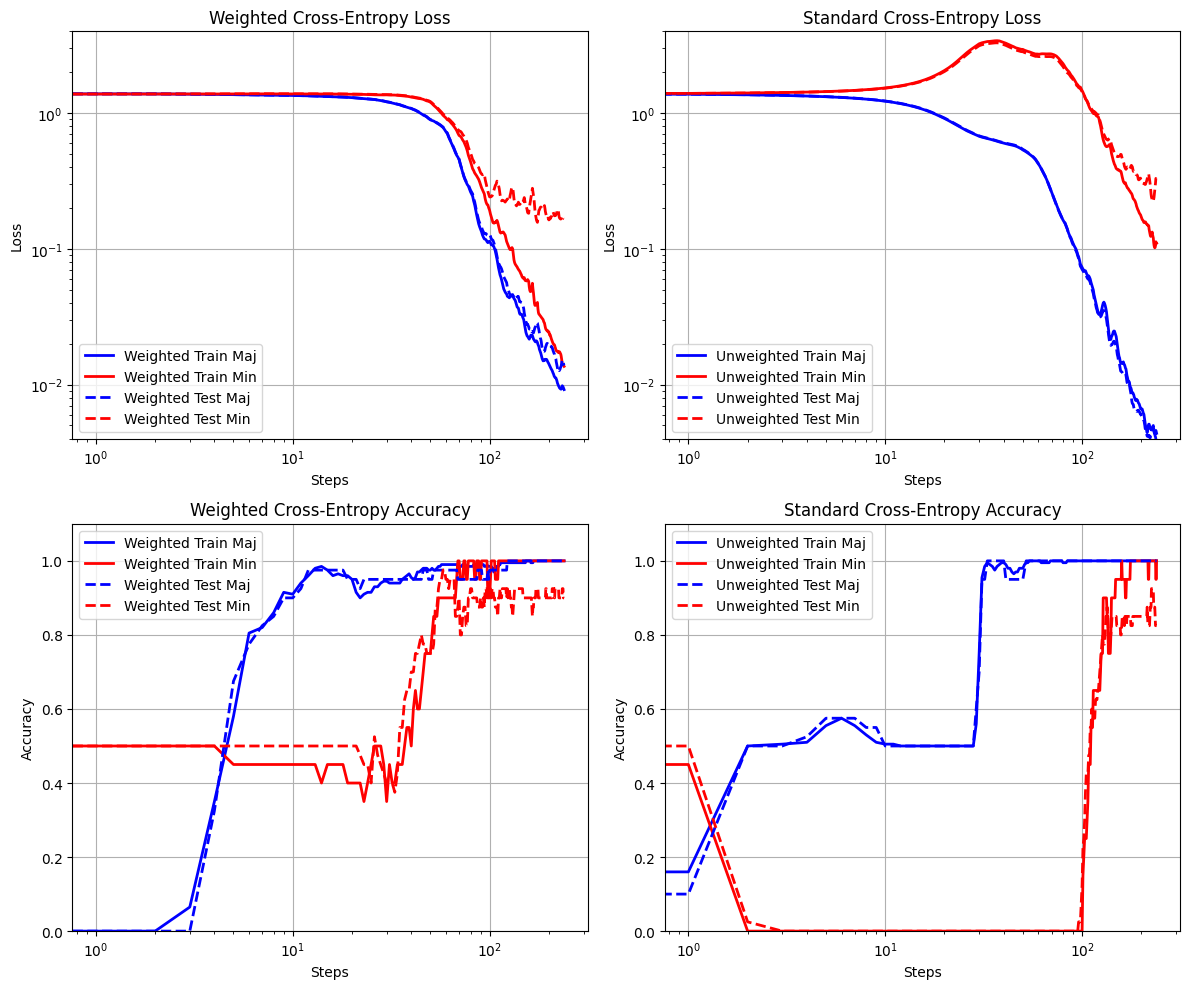

In [21]:
print("\n" + "="*80)
print("FINAL TRAINING RESULTS COMPARISON")
print("="*80)

# Display final metrics for both models
if train_metrics_weighted['steps'] and train_metrics_unweighted['steps']:
    final_step = train_metrics_weighted['steps'][-1]
    print(f"Training completed at step {final_step}")
    print("\nWEIGHTED CROSS-ENTROPY MODEL:")
    print("-" * 40)
    print(f"Final train accuracy: {train_metrics_weighted['accuracy'][-1]:.4f}")
    print(f"Final test accuracy: {test_metrics_weighted['accuracy'][-1]:.4f}")
    print(f"Final train maj/min accuracy: {train_metrics_weighted['maj_accuracy'][-1]:.4f}/{train_metrics_weighted['min_accuracy'][-1]:.4f}")
    print(f"Final test maj/min accuracy: {test_metrics_weighted['maj_accuracy'][-1]:.4f}/{test_metrics_weighted['min_accuracy'][-1]:.4f}")

    print("\nSTANDARD CROSS-ENTROPY MODEL:")
    print("-" * 40)
    print(f"Final train accuracy: {train_metrics_unweighted['accuracy'][-1]:.4f}")
    print(f"Final test accuracy: {test_metrics_unweighted['accuracy'][-1]:.4f}")
    print(f"Final train maj/min accuracy: {train_metrics_unweighted['maj_accuracy'][-1]:.4f}/{train_metrics_unweighted['min_accuracy'][-1]:.4f}")
    print(f"Final test maj/min accuracy: {test_metrics_unweighted['maj_accuracy'][-1]:.4f}/{test_metrics_unweighted['min_accuracy'][-1]:.4f}")

# Plot side-by-side metrics comparison
print("\nGenerating side-by-side visualizations...")
plot_metrics_comparison(train_metrics_weighted, test_metrics_weighted, train_metrics_unweighted, test_metrics_unweighted)

# Plot final comparison bar charts
plot_final_comparison(train_metrics_weighted, test_metrics_weighted, train_metrics_unweighted, test_metrics_unweighted, config_weighted['c_maj'], config_weighted['c_min'])

## 11. Confusion Matrix Video Generation

Create side-by-side confusion matrix comparisons and generate an MP4 video.

In [22]:
def create_side_by_side_confusion_matrices(train_cm_history_weighted, test_cm_history_weighted,
                                         train_cm_history_unweighted, test_cm_history_unweighted,
                                         c_maj, c_min, output_dir="./cm_comparison", fps=2):
    """
    Create side-by-side confusion matrix comparisons and generate MP4 video

    Args:
        train_cm_history_weighted: Training confusion matrices for weighted model
        test_cm_history_weighted: Test confusion matrices for weighted model
        train_cm_history_unweighted: Training confusion matrices for unweighted model
        test_cm_history_unweighted: Test confusion matrices for unweighted model
        c_maj: Majority classes
        c_min: Minority classes
        output_dir: Directory to save comparison images and video
        fps: Frames per second for the video
    """

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Get the minimum length to ensure we have pairs
    min_length = min(len(train_cm_history_weighted), len(train_cm_history_unweighted),
                     len(test_cm_history_weighted), len(test_cm_history_unweighted))

    if min_length == 0:
        print("No confusion matrices to process!")
        return

    print(f"Creating {min_length} side-by-side confusion matrix comparisons...")

    all_classes = c_maj + c_min
    image_files = []

    # Set up matplotlib for efficiency
    plt.ioff()  # Turn off interactive mode for faster plotting

    for i in range(min_length):
        # Create smaller figure with 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(12, 9))  # Reduced from (16, 12)

        # Calculate step number (assuming eval_steps=1)
        step = i * config_weighted['eval_steps']

        # Train Weighted CE (top-left)
        cm_norm = train_cm_history_weighted[i].astype('float') / train_cm_history_weighted[i].sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                   ax=axes[0,0], cbar=True, annot_kws={'size': 9},
                   square=True, linewidths=0.5)  # Added square=True and linewidths for better appearance
        axes[0,0].set_title(f'Train - Weighted CE (Step {step})', fontsize=12, fontweight='bold')
        axes[0,0].set_xlabel('Predicted Classes', fontsize=10)
        axes[0,0].set_ylabel('True Classes', fontsize=10)
        axes[0,0].set_xticks(np.arange(len(all_classes)) + 0.5)  # Center ticks on blocks
        axes[0,0].set_yticks(np.arange(len(all_classes)) + 0.5)  # Center ticks on blocks
        axes[0,0].set_xticklabels(['Maj1', 'Maj2', 'Min1', 'Min2'], fontsize=9)
        axes[0,0].set_yticklabels(['Maj1', 'Maj2', 'Min1', 'Min2'], fontsize=9)

        # Train Standard CE (top-right)
        cm_norm = train_cm_history_unweighted[i].astype('float') / train_cm_history_unweighted[i].sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds',
                   ax=axes[0,1], cbar=True, annot_kws={'size': 9},
                   square=True, linewidths=0.5)
        axes[0,1].set_title(f'Train - Standard CE (Step {step})', fontsize=12, fontweight='bold')
        axes[0,1].set_xlabel('Predicted Classes', fontsize=10)
        axes[0,1].set_ylabel('True Classes', fontsize=10)
        axes[0,1].set_xticks(np.arange(len(all_classes)) + 0.5)  # Center ticks on blocks
        axes[0,1].set_yticks(np.arange(len(all_classes)) + 0.5)  # Center ticks on blocks
        axes[0,1].set_xticklabels(['Maj1', 'Maj2', 'Min1', 'Min2'], fontsize=9)
        axes[0,1].set_yticklabels(['Maj1', 'Maj2', 'Min1', 'Min2'], fontsize=9)

        # Test Weighted CE (bottom-left)
        cm_norm = test_cm_history_weighted[i].astype('float') / test_cm_history_weighted[i].sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                   ax=axes[1,0], cbar=True, annot_kws={'size': 9},
                   square=True, linewidths=0.5)
        axes[1,0].set_title(f'Test - Weighted CE (Step {step})', fontsize=12, fontweight='bold')
        axes[1,0].set_xlabel('Predicted Classes', fontsize=10)
        axes[1,0].set_ylabel('True Classes', fontsize=10)
        axes[1,0].set_xticks(np.arange(len(all_classes)) + 0.5)  # Center ticks on blocks
        axes[1,0].set_yticks(np.arange(len(all_classes)) + 0.5)  # Center ticks on blocks
        axes[1,0].set_xticklabels(['Maj1', 'Maj2', 'Min1', 'Min2'], fontsize=9)
        axes[1,0].set_yticklabels(['Maj1', 'Maj2', 'Min1', 'Min2'], fontsize=9)

        # Test Standard CE (bottom-right)
        cm_norm = test_cm_history_unweighted[i].astype('float') / test_cm_history_unweighted[i].sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds',
                   ax=axes[1,1], cbar=True, annot_kws={'size': 9},
                   square=True, linewidths=0.5)
        axes[1,1].set_title(f'Test - Standard CE (Step {step})', fontsize=12, fontweight='bold')
        axes[1,1].set_xlabel('Predicted Classes', fontsize=10)
        axes[1,1].set_ylabel('True Classes', fontsize=10)
        axes[1,1].set_xticks(np.arange(len(all_classes)) + 0.5)  # Center ticks on blocks
        axes[1,1].set_yticks(np.arange(len(all_classes)) + 0.5)  # Center ticks on blocks
        axes[1,1].set_xticklabels(['Maj1', 'Maj2', 'Min1', 'Min2'], fontsize=9)
        axes[1,1].set_yticklabels(['Maj1', 'Maj2', 'Min1', 'Min2'], fontsize=9)

        # Add overall title
        fig.suptitle(f'Confusion Matrix Comparison - Step {step}\nWeighted CE (Blue) vs Standard CE (Red)',
                    fontsize=14, fontweight='bold', y=0.96)

        # plt.tight_layout()
        plt.subplots_adjust(top=0.88)  # Adjusted for smaller figure

        # Save the figure with optimized settings
        filename = f"cm_comparison_step_{step:04d}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white',
                   format='png')  # Removed optimize=True as it's not supported by matplotlib
        plt.close()  # Important: close figure to free memory

        image_files.append(filepath)

        if (i + 1) % 20 == 0:  # Reduced frequency of progress updates
            print(f"Created {i + 1}/{min_length} comparison images...")

    plt.ion()  # Turn interactive mode back on
    print(f"All {min_length} comparison images saved to {output_dir}/")

    # Create MP4 video
    create_video_from_images(image_files, output_dir, fps)

def create_video_from_images(image_files, output_dir, fps=2):
    """
    Create MP4 video from a list of image files using imageio

    Args:
        image_files: List of image file paths
        output_dir: Directory to save the video
        fps: Frames per second for the video
    """

    if not image_files:
        print("No images to create video!")
        return

    # Define video path
    video_path = os.path.join(output_dir, f"confusion_matrix_comparison_fps{fps}.mp4")

    print(f"Creating MP4 video with {len(image_files)} frames at {fps} FPS...")
    print(f"Output: {video_path}")

    try:
        # Create video writer
        with imageio.get_writer(video_path, fps=fps, codec='libx264', quality=8) as writer:
            for i, image_file in enumerate(image_files):
                try:
                    # Read image
                    image = imageio.imread(image_file)
                    writer.append_data(image)

                    if (i + 1) % 10 == 0:
                        print(f"Processed {i + 1}/{len(image_files)} frames...")

                except Exception as e:
                    print(f"Warning: Could not process image {image_file}: {e}")
                    continue

        print(f"Video saved successfully: {video_path}")
        print(f"Video details: {len(image_files)} frames, {fps} FPS, {len(image_files)/fps:.1f} seconds duration")

        # Verify the video file was created
        if os.path.exists(video_path):
            file_size = os.path.getsize(video_path) / (1024 * 1024)  # Size in MB
            print(f"Video file size: {file_size:.2f} MB")
        else:
            print("Warning: Video file was not created successfully!")

    except Exception as e:
        print(f"Error creating video: {e}")
        print("Trying alternative codec...")

        # Fallback: try with different codec
        try:
            video_path_fallback = os.path.join(output_dir, f"confusion_matrix_comparison_fps{fps}_fallback.mp4")
            with imageio.get_writer(video_path_fallback, fps=fps, codec='mpeg4') as writer:
                for i, image_file in enumerate(image_files):
                    try:
                        image = imageio.imread(image_file)
                        writer.append_data(image)
                    except Exception as e:
                        print(f"Warning: Could not process image {image_file}: {e}")
                        continue

            print(f"Fallback video saved: {video_path_fallback}")

        except Exception as e2:
            print(f"Fallback video creation also failed: {e2}")
            print("You can manually create a video from the PNG files in the output directory.")

In [23]:
# Configuration for video generation
video_fps = 5  # You can change this value to adjust video speed

print("\n" + "="*80)
print("GENERATING CONFUSION MATRIX COMPARISON VIDEO")
print("="*80)
print(f"Video FPS: {video_fps}")
print("This will create side-by-side confusion matrix comparisons and generate an MP4 video...")

# Generate the comparison video
create_side_by_side_confusion_matrices(
    train_cm_history_weighted, test_cm_history_weighted,
    train_cm_history_unweighted, test_cm_history_unweighted,
    config_weighted['c_maj'], config_weighted['c_min'],
    output_dir=save_dir_1,
    fps=video_fps
)

print("\n" + "="*80)
print("VIDEO GENERATION COMPLETE!")
print("="*80)
print(f"Check the {save_dir_1} directory for:")
print("1. Individual comparison images (cm_comparison_step_XXXX.png)")
print(f"2. MP4 video (confusion_matrix_comparison_fps{video_fps}.mp4)")
print("="*80)


# part 2: small scale experiments


GENERATING CONFUSION MATRIX COMPARISON VIDEO
Video FPS: 5
This will create side-by-side confusion matrix comparisons and generate an MP4 video...
Creating 240 side-by-side confusion matrix comparisons...
Created 20/240 comparison images...
Created 40/240 comparison images...
Created 60/240 comparison images...
Created 80/240 comparison images...
Created 100/240 comparison images...
Created 120/240 comparison images...
Created 140/240 comparison images...
Created 160/240 comparison images...
Created 180/240 comparison images...
Created 200/240 comparison images...
Created 220/240 comparison images...
Created 240/240 comparison images...
All 240 comparison images saved to ./cm_comparison/
Creating MP4 video with 240 frames at 5 FPS...
Output: ./cm_comparison/confusion_matrix_comparison_fps5.mp4


Processed 10/240 frames...
Processed 20/240 frames...
Processed 30/240 frames...
Processed 40/240 frames...
Processed 50/240 frames...
Processed 60/240 frames...
Processed 70/240 frames...
Processed 80/240 frames...
Processed 90/240 frames...
Processed 100/240 frames...
Processed 110/240 frames...
Processed 120/240 frames...
Processed 130/240 frames...
Processed 140/240 frames...
Processed 150/240 frames...
Processed 160/240 frames...
Processed 170/240 frames...
Processed 180/240 frames...
Processed 190/240 frames...
Processed 200/240 frames...
Processed 210/240 frames...
Processed 220/240 frames...
Processed 230/240 frames...
Processed 240/240 frames...
Video saved successfully: ./cm_comparison/confusion_matrix_comparison_fps5.mp4
Video details: 240 frames, 5 FPS, 48.0 seconds duration
Video file size: 2.64 MB

VIDEO GENERATION COMPLETE!
Check the ./cm_comparison directory for:
1. Individual comparison images (cm_comparison_step_XXXX.png)
2. MP4 video (confusion_matrix_comparison_fps5

In [41]:

import glob
import os
# Remove png files in cm_comparison
filelist = glob.glob(os.path.join('cm_comparison', '*.png'))
for f in filelist:
    os.remove(f)

print("Removed .png files from cn_comparison directory.")

Removed .png files from cn_comparison directory.


In [24]:
# prompt: isplay video here, make it fit to screen

from IPython.display import display, Video
video_path = os.path.join(save_dir_1, f"confusion_matrix_comparison_fps{video_fps}.mp4")

if os.path.exists(video_path):
    # Check if the video file is not empty or too small
    if os.path.getsize(video_path) > 1024: # arbitrary threshold, adjust if needed
        print(f"Displaying video from: {video_path}")
        # Display the video
        display(Video(video_path, embed=True, html_attributes='loop autoplay controls style="width: 100%;"')) # Added style="width: 100%;"
    else:
        print(f"Video file seems empty or too small. Size: {os.path.getsize(video_path)} bytes")
        print("Video playback may not work.")
else:
    print(f"Video file not found at: {video_path}")



Displaying video from: ./cm_comparison/confusion_matrix_comparison_fps5.mp4


## Part 2: Small-Scale Model – Spectral Analysis via Matrix Factorization


This part of the notebook implements matrix factorization experiments comparing different initialization methods and gradient descent variants.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import qr
from scipy.sparse import random as sparse_random
import warnings
import torch
import os
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Configurations Here:
Set re_weight = True to enable loss-reweighting

In [26]:
# Gradient descent variants (set all to False for standard GD)
spectral_GD = False
normalized_GD = False
sign_GD = False

logscalevar = False

re_weight = True

# Matrix dimensions and structure
V = 4
R = 10
# imbalanced setting
m_values = np.concatenate([R * np.ones(V//2, dtype=int), np.ones(V//2, dtype=int)])
n = np.sum(m_values)
class_freq = m_values / np.sum(m_values)

print(f"Vocabulary size V: {V}")
print(f"Context multiplier R: {R}")
print(f"Context counts per word: {m_values}")
print(f"Total number of contexts: {n}")
print(f"Class frequencies: {class_freq}")

Vocabulary size V: 4
Context multiplier R: 10
Context counts per word: [10 10  1  1]
Total number of contexts: 22
Class frequencies: [0.45454545 0.45454545 0.04545455 0.04545455]


In [27]:
def generate_one_hot_matrix(V, m_values):
    """Generate one-hot matrix with specified context counts per word"""
    total_contexts = np.sum(m_values)
    P = torch.zeros((V, total_contexts), device=device)

    col_idx = 0
    for i, m in enumerate(m_values):
        for j in range(m):
            P[i, col_idx] = 1
            col_idx += 1

    return P

def truncate_svd(A, threshold=1e-10):
    """Perform SVD and truncate small singular values using PyTorch"""
    if isinstance(A, np.ndarray):
        A = torch.from_numpy(A).to(device)

    U, s, Vt = torch.linalg.svd(A, full_matrices=False)

    # Threshold small singular values
    r = torch.sum(s > threshold * torch.max(s))
    r = min(r, len(s))

    U_trunc = U[:, :r]
    s_trunc = s[:r]
    Vt_trunc = Vt[:r, :]

    return U_trunc, torch.diag(s_trunc), Vt_trunc.T, r

def find_best_rotation(A, B):
    """Find best rotation matrix R such that ||A - BR||_F is minimized"""
    if isinstance(A, np.ndarray):
        A = torch.from_numpy(A).to(device)
    if isinstance(B, np.ndarray):
        B = torch.from_numpy(B).to(device)

    U, _, Vt = torch.linalg.svd(A.T @ B, full_matrices=False)
    return U @ Vt

def seismic_colormap():
    """Create blue-white-red colormap similar to MATLAB's seismic"""
    from matplotlib.colors import LinearSegmentedColormap
    colors = ['blue', 'lightblue', 'white', 'lightcoral', 'red']
    n_bins = 256
    cmap = LinearSegmentedColormap.from_list('seismic', colors, N=n_bins)
    return cmap

def safe_divide(num, den):
    """Safe division that handles GPU tensors"""
    if den == 0:
        return torch.tensor(0.0, device=device)
    return num / den

def to_numpy(tensor):
    """Convert a GPU/CPU tensor to numpy array"""
    if tensor is None:
        return None
    if torch.is_tensor(tensor):
        return tensor.cpu().detach().numpy()
    return tensor

In [28]:
# Generate the one-hot matrix P
P = generate_one_hot_matrix(V, m_values)
print(f"Generated matrix P with shape: {P.shape}")

# Matrix dimensions
V, m = P.shape
d = V  # embedding dimension



if re_weight:
# Weights for different word types
    weights = torch.cat([torch.sqrt(torch.tensor(n/R)) * torch.ones(V//2), torch.sqrt(torch.tensor(n)) * torch.ones(V//2)]).to(device)
    # weights = weights / weights[0]

else:
    weights = torch.ones(V, device=device, dtype=torch.float32)



print(f"Weights: {weights}")

# Create sparsity matrix So (support matrix)
So = (P != 0).float()

# Create weighted diagonal matrix D
D = torch.diag(So.T @ weights)

print(f"Support matrix So shape: {So.shape}")
print(f"Diagonal matrix D shape: {D.shape}")

Generated matrix P with shape: torch.Size([4, 22])
Weights: tensor([1.4832, 1.4832, 4.6904, 4.6904], device='cuda:0')
Support matrix So shape: torch.Size([4, 22])
Diagonal matrix D shape: torch.Size([22, 22])


In [29]:
# Create centered matrix S
S = (torch.eye(V, device=device) - torch.ones((V, V), device=device)/V) @ So
print(f"Centered matrix S shape: {S.shape}")

# Perform SVD and truncate
U, Sigma, Vmat, r = truncate_svd(S, threshold=1e-10)
singular_values = torch.diag(Sigma)

print(f"SVD results:")
print(f"  Rank r: {r}")
print(f"  Singular values: {singular_values}")
print(f"  U shape: {U.shape}")
print(f"  Sigma shape: {Sigma.shape}")
print(f"  V shape: {Vmat.shape}")

Centered matrix S shape: torch.Size([4, 22])
SVD results:
  Rank r: 4
  Singular values: tensor([3.1623e+00, 2.3452e+00, 1.0000e+00, 1.9420e-07], device='cuda:0')
  U shape: torch.Size([4, 4])
  Sigma shape: torch.Size([4, 4])
  V shape: torch.Size([22, 4])


In [30]:
# Create partial rotation matrix R
Q = torch.randn(d, r, device=device)
Q, _ = torch.linalg.qr(Q)
R = Q[:, :r]

# Initialize matrices for both schemes
delta = 10

# Random initialization
W1 = torch.randn(V, d, device=device) / torch.sqrt(torch.tensor(d))
H1 = torch.randn(d, m, device=device) / torch.sqrt(torch.tensor(m))

# SVD-based initialization
H2 = torch.exp(torch.tensor(-delta)) * R @ Vmat.T
W2 = torch.exp(torch.tensor(-delta)) * U @ R.T

# Normalize random initialization to same scale as SVD-based
H1 = H1 / torch.norm(H1, 'fro') * torch.norm(H2, 'fro')
W1 = W1 / torch.norm(W1, 'fro') * torch.norm(W2, 'fro')

print("Initialization complete:")
print(f"  W1 norm: {torch.norm(W1, 'fro'):.6f}")
print(f"  H1 norm: {torch.norm(H1, 'fro'):.6f}")
print(f"  W2 norm: {torch.norm(W2, 'fro'):.6f}")
print(f"  H2 norm: {torch.norm(H2, 'fro'):.6f}")

Initialization complete:
  W1 norm: 0.000091
  H1 norm: 0.000091
  W2 norm: 0.000091
  H2 norm: 0.000091


In [31]:
# Training parameters
max_iter = 100000
learning_rate = 0.01

if spectral_GD or normalized_GD or sign_GD:
    learning_rate = 0.05

print(f"Training parameters:")
print(f"  Max iterations: {max_iter}")
print(f"  Learning rate: {learning_rate}")
print(f"  Spectral GD: {spectral_GD}")
print(f"  Normalized GD: {normalized_GD}")
print(f"  Sign GD: {sign_GD}")

# Initialize storage arrays
max_iter_plus = max_iter + 1
losses1 = torch.zeros(max_iter_plus, device=device)
losses2 = torch.zeros(max_iter_plus, device=device)
W_norms1 = torch.zeros(max_iter_plus, device=device)
H_norms1 = torch.zeros(max_iter_plus, device=device)
W_norms2 = torch.zeros(max_iter_plus, device=device)
H_norms2 = torch.zeros(max_iter_plus, device=device)
metrics1 = torch.zeros((max_iter_plus, 3), device=device)
metrics2 = torch.zeros((max_iter_plus, 3), device=device)

# Additional tracking arrays
W_offdiagenergy = torch.zeros(max_iter_plus, device=device)
H_offdiagenergy = torch.zeros(max_iter_plus, device=device)
L1_offdiagenergy = torch.zeros(max_iter_plus, device=device)
L_offdiagenergy = torch.zeros(max_iter_plus, device=device)

U_W_diag1 = torch.full((max_iter_plus, min(V, m)), torch.nan, device=device)
U_W_diag2 = torch.full((max_iter_plus, r), torch.nan, device=device)
H_V_diag1 = torch.full((max_iter_plus, min(V, m)), torch.nan, device=device)
H_V_diag2 = torch.full((max_iter_plus, r), torch.nan, device=device)
L1_diag = torch.full((max_iter_plus, min(V, m)), torch.nan, device=device)
L_diag = torch.full((max_iter_plus, r), torch.nan, device=device)

print("Storage arrays initialized")

Training parameters:
  Max iterations: 100000
  Learning rate: 0.01
  Spectral GD: False
  Normalized GD: False
  Sign GD: False
Storage arrays initialized


In [32]:
# Initial matrix products
L1 = W1 @ H1  # Random initialization product
L = W2 @ H2   # SVD initialization product

# Initial losses
losses1[0] = 0.5/m * torch.norm(S - L1, 'fro')**2
losses2[0] = 0.5/m * torch.norm(S - L, 'fro')**2

# Initial norms
W_norms1[0] = torch.norm(W1, 'fro')
H_norms1[0] = torch.norm(H1, 'fro')
W_norms2[0] = torch.norm(W2, 'fro')
H_norms2[0] = torch.norm(H2, 'fro')

# Initial metrics
metrics1[0, :] = torch.tensor([
    torch.norm(W1 @ W1.T - U @ Sigma @ U.T, 'fro'),
    torch.norm(H1.T @ H1 - Vmat @ Sigma @ Vmat.T, 'fro'),
    torch.norm(L1 - S, 'fro')
], device=device)

metrics2[0, :] = torch.tensor([
    torch.norm(W2 @ W2.T - U @ Sigma @ U.T, 'fro'),
    torch.norm(H2.T @ H2 - Vmat @ Sigma @ Vmat.T, 'fro'),
    torch.norm(L - S, 'fro')
], device=device)

# Calculate rotations for random initialization
U_tilde, Sigma_tilde, V_tilde, r_tilde = truncate_svd(L1, 1e-10)
RW1 = find_best_rotation(U_tilde @ torch.sqrt(Sigma_tilde), W1).T
RH1 = find_best_rotation(V_tilde @ torch.sqrt(Sigma_tilde), H1.T).T

# Initial diagonal tracking
if r_tilde > 0:
    U_W_diag1[0, :r_tilde] = torch.diag(U_tilde.T @ W1 @ RW1)
    H_V_diag1[0, :r_tilde] = torch.diag(RH1.T @ H1 @ V_tilde)

U_W_diag2[0, :] = torch.diag(U.T @ W2 @ R)
H_V_diag2[0, :] = torch.diag(R.T @ H2 @ Vmat)

# Initial off-diagonal energy
W_offdiagenergy[0] = safe_divide(
    torch.norm(U.T @ W2 @ R - torch.diag(torch.diag(U.T @ W2 @ R)), 'fro'),
    torch.norm(torch.diag(U.T @ W2 @ R))
)

H_offdiagenergy[0] = safe_divide(
    torch.norm(R.T @ H2 @ Vmat - torch.diag(torch.diag(R.T @ H2 @ Vmat)), 'fro'),
    torch.norm(torch.diag(R.T @ H2 @ Vmat))
)

# Initial L diagonal and off-diagonal energy
L1_diag[0, :r] = torch.diag(U.T @ L1 @ Vmat)
L_diag[0, :] = torch.diag(U.T @ L @ Vmat)

L1_offdiagenergy[0] = safe_divide(
    torch.norm(U.T @ L1 @ Vmat - torch.diag(torch.diag(U.T @ L1 @ Vmat)), 'fro'),
    torch.norm(L1, 'fro')
)

L_offdiagenergy[0] = safe_divide(
    torch.norm(U.T @ L @ Vmat - torch.diag(torch.diag(U.T @ L @ Vmat)), 'fro'),
    torch.norm(L, 'fro')
)

print("Initial computations completed")

Initial computations completed


In [33]:
print("Starting training loop...")

for k in range(max_iter):
    # First initialization (Random)
    WH1 = W1 @ H1
    loss1 = 0.5/m * torch.norm(S - WH1, 'fro')**2
    losses1[k+1] = loss1

    # Compute gradients
    dWH1 = (WH1 - S) @ D / m
    dW1 = dWH1 @ H1.T
    dH1 = W1.T @ dWH1

    # Apply gradient modifications
    if spectral_GD:
        Uw, Sw, Vw, _ = truncate_svd(dW1, 1e-4)
        Uh, Sh, Vh, _ = truncate_svd(dH1, 1e-4)
        dW1 = torch.sum(torch.diag(Sw)) * Uw @ Vw.T
        dH1 = torch.sum(torch.diag(Sh)) * Uh @ Vh.T

    if normalized_GD:
        dW1 = dW1 / torch.norm(dW1, 'fro')
        dH1 = dH1 / torch.norm(dH1, 'fro')

    if sign_GD:
        dW1 = torch.sign(dW1)
        dH1 = torch.sign(dH1)

    # Update parameters
    W1 = W1 - learning_rate * dW1
    H1 = H1 - learning_rate * dH1

    # Second initialization (SVD)
    WH2 = W2 @ H2
    loss2 = 0.5/m * torch.norm(S - WH2, 'fro')**2
    losses2[k+1] = loss2

    # Compute gradients
    dWH2 = (WH2 - S) @ D / m
    dW2 = dWH2 @ H2.T
    dH2 = W2.T @ dWH2

    # Apply gradient modifications
    if spectral_GD:
        Uw, Sw, Vw, _ = truncate_svd(dW2, 1e-4)
        Uh, Sh, Vh, _ = truncate_svd(dH2, 1e-4)
        dW2 = torch.sum(torch.diag(Sw)) * Uw @ Vw.T
        dH2 = torch.sum(torch.diag(Sh)) * Uh @ Vh.T

    if normalized_GD:
        dW2 = dW2 / torch.norm(dW2, 'fro')
        dH2 = dH2 / torch.norm(dH2, 'fro')

    if sign_GD:
        dW2 = torch.sign(dW2)
        dH2 = torch.sign(dH2)

    # Update parameters
    W2 = W2 - learning_rate * dW2
    H2 = H2 - learning_rate * dH2

    # Store norms
    W_norms1[k+1] = torch.norm(W1, 'fro')
    H_norms1[k+1] = torch.norm(H1, 'fro')
    W_norms2[k+1] = torch.norm(W2, 'fro')
    H_norms2[k+1] = torch.norm(H2, 'fro')

    # Calculate metrics
    metrics1[k+1, :] = torch.tensor([
        torch.norm(W1 @ W1.T - U @ Sigma @ U.T, 'fro'),
        torch.norm(H1.T @ H1 - Vmat @ Sigma @ Vmat.T, 'fro'),
        torch.norm(W1 @ H1 - U @ Sigma @ Vmat.T, 'fro')
    ], device=device)

    metrics2[k+1, :] = torch.tensor([
        torch.norm(W2 @ W2.T - U @ Sigma @ U.T, 'fro'),
        torch.norm(H2.T @ H2 - Vmat @ Sigma @ Vmat.T, 'fro'),
        torch.norm(W2 @ H2 - U @ Sigma @ Vmat.T, 'fro')
    ], device=device)

    # Calculate rotations and diagonal tracking
    U_tilde, Sigma_tilde, V_tilde, r_tilde = truncate_svd(W1 @ H1, 1e-10)
    RW1 = find_best_rotation(U_tilde @ torch.sqrt(Sigma_tilde), W1).T
    RH1 = find_best_rotation(V_tilde @ torch.sqrt(Sigma_tilde), H1.T).T

    if r_tilde > 0:
        U_W_diag1[k, :r_tilde] = torch.diag(U_tilde.T @ W1 @ RW1)
        H_V_diag1[k, :r_tilde] = torch.diag(RH1.T @ H1 @ V_tilde)

    U_W_diag2[k, :] = torch.diag(U.T @ W2 @ R)
    H_V_diag2[k, :] = torch.diag(R.T @ H2 @ Vmat)

    # Off-diagonal energy calculations
    W_offdiagenergy[k] = safe_divide(
        torch.norm(U.T @ W2 @ R - torch.diag(torch.diag(U.T @ W2 @ R)), 'fro'),
        torch.norm(torch.diag(U.T @ W2 @ R))
    )

    H_offdiagenergy[k] = safe_divide(
        torch.norm(R.T @ H2 @ Vmat - torch.diag(torch.diag(R.T @ H2 @ Vmat)), 'fro'),
        torch.norm(torch.diag(R.T @ H2 @ Vmat))
    )

    L1 = W1 @ H1
    L = W2 @ H2

    L1_diag[k, :r] = torch.diag(U.T @ L1 @ Vmat)
    L_diag[k, :] = torch.diag(U.T @ L @ Vmat)

    L1_offdiagenergy[k] = safe_divide(
        torch.norm(U.T @ L1 @ Vmat - torch.diag(torch.diag(U.T @ L1 @ Vmat)), 'fro'),
        torch.norm(L1, 'fro')
    )

    L_offdiagenergy[k] = safe_divide(
        torch.norm(U.T @ L @ Vmat - torch.diag(torch.diag(U.T @ L @ Vmat)), 'fro'),
        torch.norm(L, 'fro')
    )

    # Progress reporting
    if (k + 1) % 10000 == 0:
        print(f'Iteration {k+1}: Loss (Random) = {losses1[k+1]:.2e}, Loss (SVD) = {losses2[k+1]:.2e}')

print("Training completed!")

Starting training loop...
Iteration 10000: Loss (Random) = 4.16e-10, Loss (SVD) = 8.01e-11
Iteration 20000: Loss (Random) = 9.10e-11, Loss (SVD) = 7.12e-11
Iteration 30000: Loss (Random) = 8.92e-11, Loss (SVD) = 7.06e-11
Iteration 40000: Loss (Random) = 8.92e-11, Loss (SVD) = 7.06e-11
Iteration 50000: Loss (Random) = 8.92e-11, Loss (SVD) = 7.06e-11
Iteration 60000: Loss (Random) = 8.92e-11, Loss (SVD) = 7.06e-11
Iteration 70000: Loss (Random) = 8.92e-11, Loss (SVD) = 7.06e-11
Iteration 80000: Loss (Random) = 8.92e-11, Loss (SVD) = 7.06e-11
Iteration 90000: Loss (Random) = 8.92e-11, Loss (SVD) = 7.06e-11
Iteration 100000: Loss (Random) = 8.92e-11, Loss (SVD) = 7.06e-11
Training completed!


In [34]:
# Calculate sigma_sqrt for reference lines
sigma_sqrt = torch.sqrt(torch.diag(Sigma))

# Create iteration range
iter_range = torch.arange(max_iter + 1)

# Set up matplotlib style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['lines.linewidth'] = 1.5

# Create output directory for plots
plot_dir = "./simulation_plots"
os.makedirs(plot_dir, exist_ok=True)
print(f"Saving plots to directory: {plot_dir}")

# Define colors
colors = [
    [0.0000, 0.4470, 0.7410],  # Blue
    [0.8500, 0.3250, 0.0980],  # Orange
    [0.4940, 0.1840, 0.5560],  # Purple
    [0.4660, 0.6740, 0.1880]   # Green
]

# Parameters for plotting
start_iter = 10
iter_range_plot = torch.arange(start_iter, max_iter + 1)

# Calculate convergence iterations
conv_threshold = 1e-4
conv_iter_1 = np.where(to_numpy(losses1[start_iter:]) < conv_threshold)[0] + start_iter
conv_iter_2 = np.where(to_numpy(losses2[start_iter:]) < conv_threshold)[0] + start_iter

print("Visualization setup complete")

Saving plots to directory: ./simulation_plots
Visualization setup complete


In [35]:
import matplotlib
plt.rcParams['font.family'] = 'serif'

In [36]:
import matplotlib.pyplot as plt
import os
import matplotlib

# Global style configuration
matplotlib.rcParams.update({
    'font.family': 'serif',
    'axes.labelsize': 11,
    'axes.titlesize': 11,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
})

def plot_results(iter_range_plot, losses1, losses2, W_norms1, H_norms1, W_norms2, H_norms2,
                metrics1, metrics2, L1_diag, L_diag, L1_offdiagenergy, L_offdiagenergy, start_iter):

    # Helper to_numpy
    to_np = lambda x: x.detach().cpu().numpy() if hasattr(x, 'detach') else x

    # Convert tensors to numpy
    iter_range_plot_np = to_np(iter_range_plot)
    losses1_np = to_np(losses1[start_iter:])
    losses2_np = to_np(losses2[start_iter:])
    W_norms1_np = to_np(W_norms1[start_iter:])
    H_norms1_np = to_np(H_norms1[start_iter:])
    W_norms2_np = to_np(W_norms2[start_iter:])
    H_norms2_np = to_np(H_norms2[start_iter:])
    metrics1_np = to_np(metrics1[start_iter:])
    metrics2_np = to_np(metrics2[start_iter:])
    L1_diag_np = to_np(L1_diag)
    L_diag_np = to_np(L_diag)
    L1_offdiagenergy_np = to_np(L1_offdiagenergy)
    L_offdiagenergy_np = to_np(L_offdiagenergy)

    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    fig.suptitle('Matrix Factorization Training Results', fontsize=16, fontweight='bold')

    # Plot 1: Loss and Norms
    ax1 = axes[0]
    ax1_twin = ax1.twinx()

    ax1.semilogy(iter_range_plot_np, losses1_np, '-', color=colors[0], label='Loss (Rand)')
    ax1.semilogy(iter_range_plot_np, losses2_np, '-', color=colors[1], label='Loss (SVD)')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss (log scale)', color='blue')
    ax1.set_xscale('log')
    ax1.grid(True, alpha=0.3)

    ax1_twin.plot(iter_range_plot_np, W_norms1_np, '--', color=colors[0], label=r'$\|W\|_F$ (Rand)')
    ax1_twin.plot(iter_range_plot_np, H_norms1_np, ':', color=colors[0], label=r'$\|H\|_F$ (Rand)')
    ax1_twin.plot(iter_range_plot_np, W_norms2_np, '--', color=colors[1], label=r'$\|W\|_F$ (SVD)')
    ax1_twin.plot(iter_range_plot_np, H_norms2_np, ':', color=colors[1], label=r'$\|H\|_F$ (SVD)')
    ax1_twin.set_ylabel('Matrix Norms', color='orangered')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    ax1.set_title('Loss and Norms Convergence')

    # Plot 2: Metrics
    ax2 = axes[1]
    ax2.plot(iter_range_plot_np, metrics1_np[:, 0], '-', color=colors[0], label=r'$WW^\top$ (Rand)')
    ax2.plot(iter_range_plot_np, metrics1_np[:, 1], '--', color=colors[0], label=r'$H^\top H$ (Rand)')
    ax2.plot(iter_range_plot_np, metrics1_np[:, 2], ':', color=colors[0], label=r'$WH$ (Rand)')
    ax2.plot(iter_range_plot_np, metrics2_np[:, 0], '-', color=colors[1], label=r'$WW^\top$ (SVD)')
    ax2.plot(iter_range_plot_np, metrics2_np[:, 1], '--', color=colors[1], label=r'$H^\top H$ (SVD)')
    ax2.plot(iter_range_plot_np, metrics2_np[:, 2], ':', color=colors[1], label=r'$WH$ (SVD)')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Iteration')
    ax2.legend(loc='best')
    ax2.set_title('Convergence to Theory')
    ax2.grid(True, alpha=0.3)

    # Plot 3: Diagonal Entries
    ax3 = axes[2]
    for i in range(L1_diag.shape[1]):
        if not torch.all(torch.isnan(L1_diag[start_iter:, i])):
            ax3.plot(iter_range_plot_np, L1_diag_np[start_iter:, i], '-', color=colors[0], alpha=0.7, label='Rand' if i == 0 else '')

    for i in range(L_diag.shape[1]):
        ax3.plot(iter_range_plot_np, L_diag_np[start_iter:, i], '-', color=colors[1], alpha=0.7, label='SVD' if i == 0 else '')

    for i, val in enumerate(to_numpy(sigma_sqrt**2)):
        ax3.axhline(y=val, color='black', linestyle='--', alpha=0.7, linewidth=1, label=r'$\Sigma$' if i == 0 else '')

    ax3.set_xscale('log')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel(r'$\mathrm{diag}(U^\top L V)$')
    ax3.set_ylim(bottom=0)
    ax3.set_title('Diagonal Entries')
    ax3.legend(loc='best')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Off-diagonal Energy
    ax4 = axes[3]
    ax4.plot(iter_range_plot_np, L1_offdiagenergy_np[start_iter:], '-', color=colors[0], label='Rand')
    ax4.plot(iter_range_plot_np, L_offdiagenergy_np[start_iter:], '-', color=colors[1], label='SVD')
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel(r'$||\mathrm{offdiag}(U^\top L V)|| / ||L||$')
    ax4.set_title('Energy of Off-Diagonal Entries')
    ax4.legend(loc='best')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'training_results.png'), dpi=500, bbox_inches='tight')
    plt.close()


# Call the plotting function
plot_results(iter_range_plot, losses1, losses2, W_norms1, H_norms1, W_norms2, H_norms2,
            metrics1, metrics2, L1_diag, L_diag, L1_offdiagenergy, L_offdiagenergy, start_iter)

In [37]:
def plot_diagonal_entries(iter_range, U_W_diag1, U_W_diag2, H_V_diag1, H_V_diag2, sigma_sqrt, logscalevar):
    # Convert tensors to numpy for plotting
    iter_range_np = to_numpy(iter_range)
    U_W_diag1_np = to_numpy(U_W_diag1)
    U_W_diag2_np = to_numpy(U_W_diag2)
    H_V_diag1_np = to_numpy(H_V_diag1)
    H_V_diag2_np = to_numpy(H_V_diag2)
    sigma_sqrt_np = to_numpy(sigma_sqrt)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Diagonal Entries of W and H Components', fontsize=14, fontweight='bold')

    # Plot diagonal entries of W
    for i in range(U_W_diag1.shape[1]):
        if not torch.all(torch.isnan(U_W_diag1[:, i])):
            ax1.plot(iter_range_np, U_W_diag1_np[:, i], '-', color=colors[0], alpha=0.7,
                    label='Rand' if i == 0 else '')

    for i in range(U_W_diag2.shape[1]):
        ax1.plot(iter_range_np, U_W_diag2_np[:, i], '-', color=colors[1], alpha=0.7,
                label='SVD' if i == 0 else '')

    # Reference lines for sqrt(sigma)
    for i, val in enumerate(sigma_sqrt_np):
        ax1.axhline(y=val, color='black', linestyle='--', alpha=0.7,
                   label='√σ' if i == 0 else '')

    if logscalevar:
        ax1.set_xscale('log')
    ax1.set_ylabel('Diagonal Entries diag(U^T W R)')
    ax1.set_xlabel('Iteration')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)

    # Plot diagonal entries of H
    for i in range(H_V_diag1.shape[1]):
        if not torch.all(torch.isnan(H_V_diag1[:, i])):
            ax2.plot(iter_range_np, H_V_diag1_np[:, i], '-', color=colors[0], alpha=0.7,
                    label='Rand' if i == 0 else '')

    for i in range(H_V_diag2.shape[1]):
        ax2.plot(iter_range_np, H_V_diag2_np[:, i], '-', color=colors[1], alpha=0.7,
                label='SVD' if i == 0 else '')

    # Reference lines for sqrt(sigma)
    for i, val in enumerate(sigma_sqrt_np):
        ax2.axhline(y=val, color='black', linestyle='--', alpha=0.7,
                   label='√σ' if i == 0 else '')

    if logscalevar:
        ax2.set_xscale('log')
    ax2.set_ylabel('Diagonal Entries diag(R^T H V)')
    ax2.set_xlabel('Iteration')
    ax2.legend(loc='best')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'diagonal_entries.png'), dpi=300, bbox_inches='tight')
    plt.close()

# Call the plotting function
plot_diagonal_entries(iter_range, U_W_diag1, U_W_diag2, H_V_diag1, H_V_diag2, sigma_sqrt, logscalevar)

In [38]:
# Create seismic colormap
cmap = seismic_colormap()

# Convert tensors to CPU numpy arrays
So_np = So.cpu().numpy()
U_np = U.cpu().numpy()
Vmat_np = Vmat.cpu().numpy()
singular_values_np = singular_values.cpu().numpy()

fig, axes = plt.subplots(1, 4, figsize=(18, 5))
fig.suptitle('SVD Components and Support Matrix', fontsize=16, fontweight='bold')

# Support Matrix
im1 = axes[0].imshow(So_np, cmap=cmap, aspect='auto')
axes[0].set_title('Support Matrix S', fontweight='bold')
axes[0].set_xlabel('Context Index')
axes[0].set_ylabel('Word Index')
plt.colorbar(im1, ax=axes[0], label='Value')

# Left Singular Vectors
im2 = axes[1].imshow(U_np, cmap=cmap, aspect='auto')
axes[1].set_title('Left Singular Vectors U', fontweight='bold')
axes[1].set_xlabel('Concept Index')
axes[1].set_ylabel('Words')
plt.colorbar(im2, ax=axes[1], label='Value')

# Singular Values
axes[2].semilogy(range(1, len(singular_values_np) + 1), singular_values_np, 'o-',
                color=colors[0], linewidth=2, markersize=8, markerfacecolor=colors[0])
axes[2].set_title('Singular Values Σ', fontweight='bold')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Value (log scale)')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([1, len(singular_values_np)])

# Right Singular Vectors
im4 = axes[3].imshow(Vmat_np, cmap=cmap, aspect='auto')
axes[3].set_title('Right Singular Vectors V', fontweight='bold')
axes[3].set_xlabel('Concept Index')
axes[3].set_ylabel('Contexts')
plt.colorbar(im4, ax=axes[3], label='Value')

plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'svd_components.png'), dpi=300, bbox_inches='tight')
plt.close()

print(f"\nAll plots have been saved to: {plot_dir}")


All plots have been saved to: ./simulation_plots


In [39]:
def print_summary_statistics(losses1, losses2, conv_iter_1, conv_iter_2, W_norms1, H_norms1,
                           W_norms2, H_norms2, metrics1, metrics2, singular_values):
    print("=" * 60)
    print("TRAINING SUMMARY")
    print("=" * 60)

    # Convert tensors to CPU numpy for printing
    losses1_np = to_numpy(losses1)
    losses2_np = to_numpy(losses2)
    W_norms1_np = to_numpy(W_norms1)
    H_norms1_np = to_numpy(H_norms1)
    W_norms2_np = to_numpy(W_norms2)
    H_norms2_np = to_numpy(H_norms2)
    metrics1_np = to_numpy(metrics1)
    metrics2_np = to_numpy(metrics2)
    singular_values_np = to_numpy(singular_values)

    # Final losses
    print(f"\nFinal Losses:")
    print(f"  Random initialization: {losses1_np[-1]:.6e}")
    print(f"  SVD initialization:    {losses2_np[-1]:.6e}")
    print(f"  Improvement ratio:     {losses1_np[-1]/losses2_np[-1]:.2f}x")

    # Convergence analysis
    print(f"\nConvergence Analysis (threshold: {conv_threshold:.0e}):")
    if len(conv_iter_1) > 0:
        print(f"  Random init converged at iteration: {conv_iter_1[0]}")
    else:
        print(f"  Random init did not converge")

    if len(conv_iter_2) > 0:
        print(f"  SVD init converged at iteration:    {conv_iter_2[0]}")
    else:
        print(f"  SVD init did not converge")

    # Matrix properties
    print(f"\nFinal Matrix Properties:")
    print(f"  W1 norm: {W_norms1_np[-1]:.4f}")
    print(f"  H1 norm: {H_norms1_np[-1]:.4f}")
    print(f"  W2 norm: {W_norms2_np[-1]:.4f}")
    print(f"  H2 norm: {H_norms2_np[-1]:.4f}")

    # Theoretical alignment
    print(f"\nAlignment with Theory (final iteration):")
    print(f"  Random - WW^T error:  {metrics1_np[-1, 0]:.6e}")
    print(f"  Random - H^TH error:  {metrics1_np[-1, 1]:.6e}")
    print(f"  Random - WH error:    {metrics1_np[-1, 2]:.6e}")
    print(f"  SVD - WW^T error:     {metrics2_np[-1, 0]:.6e}")
    print(f"  SVD - H^TH error:     {metrics2_np[-1, 1]:.6e}")
    print(f"  SVD - WH error:       {metrics2_np[-1, 2]:.6e}")

    print(f"\nSingular Values:")
    for i, val in enumerate(singular_values_np):
        print(f"  σ_{i+1} = {val:.6f} (σ_{i+1}² = {val**2:.6f})")

    print("=" * 60)

# Call the summary statistics function
print_summary_statistics(losses1, losses2, conv_iter_1, conv_iter_2, W_norms1, H_norms1,
                       W_norms2, H_norms2, metrics1, metrics2, singular_values)

TRAINING SUMMARY

Final Losses:
  Random initialization: 8.924358e-11
  SVD initialization:    7.060744e-11
  Improvement ratio:     1.26x

Convergence Analysis (threshold: 1e-04):
  Random init converged at iteration: 6900
  SVD init converged at iteration:    6367

Final Matrix Properties:
  W1 norm: 2.5509
  H1 norm: 2.5510
  W2 norm: 2.5509
  H2 norm: 2.5510

Alignment with Theory (final iteration):
  Random - WW^T error:  1.442030e-04
  Random - H^TH error:  9.923706e-05
  Random - WH error:    6.249200e-05
  SVD - WW^T error:     1.452564e-04
  SVD - H^TH error:     5.881829e-05
  SVD - WH error:       5.516759e-05

Singular Values:
  σ_1 = 3.162278 (σ_1² = 10.000000)
  σ_2 = 2.345208 (σ_2² = 5.499999)
  σ_3 = 1.000000 (σ_3² = 1.000000)
  σ_4 = 0.000000 (σ_4² = 0.000000)


In [40]:
# Move tensors back to CPU and clear CUDA cache if used
if torch.cuda.is_available():
    torch.cuda.empty_cache()